In [2]:
from pathlib import Path # Manage folders and files
import rasterio as rio # Reads and writes geospatial raster data
from matplotlib import pyplot as plt # Display plots and images
import numpy as np # Multi-dimensional arrays
import sap # To create morphological trees

# Attribute profiles (APs)

![](img/aps.png)

## 0. Setup: Load the DSM tile and compute the max-tree

- Load the dsm tile `tile_path`.
- Compute the max-tree.

In [8]:
tile_path = Path('data/dsm_vox_50cm_tile_-12_0.tif')
# dsm = None # You know what to do 🙂
# max_tree = None # You can do it!


with rio.open(tile_path) as src:
    dsm = src.read(1)  # Read the first band
dsm_no_nan = np.nan_to_num(dsm, nan=-9999)
dsm_no_nan = dsm_no_nan.astype(np.float16)
print(dsm_no_nan)

# # Mask NoData
# if dsm is not None:
#     dsm[dsm == dsm] = np.nan

# # Replace NaN with min-1
# dsm_no_nan = np.copy(dsm)
# dsm_no_nan[np.isnan(dsm_no_nan)] = np.nanmin(dsm) - 1
# print(dsm_no_nan)

max_tree = sap.MaxTree(dsm_no_nan)
print(max_tree.num_nodes)

[[29.14 29.12 29.12 ... 50.75 53.16 52.88]
 [29.16 29.14 29.12 ... 48.75 53.9  53.9 ]
 [30.58 29.97 29.11 ... 50.56 54.6  54.25]
 ...
 [43.56 43.53 43.56 ... 48.3  48.53 45.38]
 [43.12 43.16 43.16 ... 46.94 47.22 45.84]
 [42.97 42.7  43.   ... 46.06 47.12 46.53]]
<bound method Tree.num_nodes of MaxTree{'adjacency': 4,
 'image.dtype': dtype('float16'),
 'image.shape': (2001, 2001),
 'image_hash': '4d9ddb6b',
 'image_name': None,
 'num_nodes': 4081221}>


In [5]:
dsm_no_nan.dtype

dtype('float16')

## 1. Create the (max) attribute profiles of the DSM 

Compute the attribute profiles of the DSM with the max-tree *only* (normally it's min and max tree).

- Choose an attribute (e.g. `area`)
- Set several thresholds (e.g. `[1000, 10000, 100000]`)
- Filter the tree according to these thresholds, stack the filtered images!
- Display the profiles (as in the intro image)

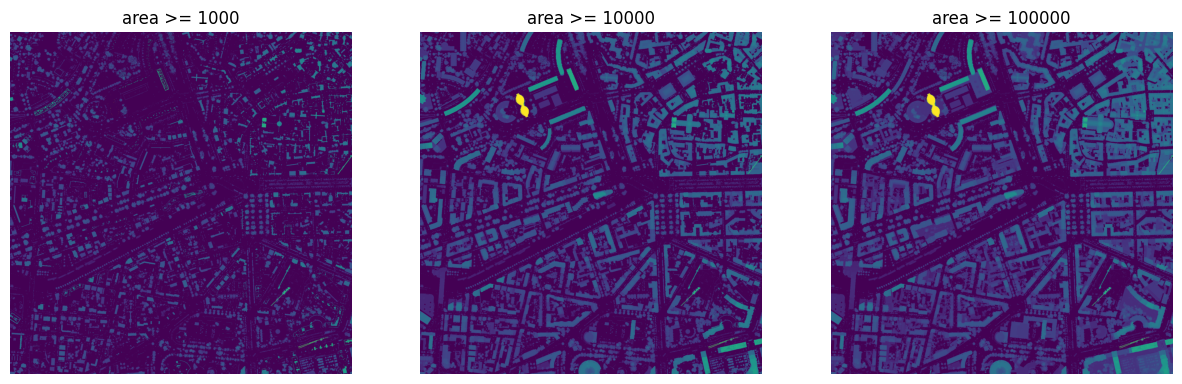

In [ ]:
# Your turn!

thresholds = [1000, 10000, 100000]

# area attribute vector
attr = max_tree.get_attribute('area')

# AP
profile = []
for th in thresholds:
    # Keep only nodes above threshold
    filtered = max_tree.reconstruct(attr >= th)
    profile.append(filtered)

# Stack into a 3D array
profile_array = np.stack(profile, axis=-1)  # shape: (height, width, n_thresholds)

# plotting
plt.figure(figsize=(15, 5))
for i, th in enumerate(thresholds):
    plt.subplot(1, len(thresholds), i+1)
    plt.imshow(profile_array[:, :, i], cmap="viridis")
    plt.title(f"{'area'} >= {th}")
    plt.axis("off")
plt.show()


In [15]:
profile[:10]

[array([[16, 16, 16, ..., 50, 53, 52],
        [16, 16, 16, ..., 16, 53, 53],
        [30, 16, 16, ..., 50, 54, 54],
        ...,
        [43, 43, 43, ..., 48, 48, 45],
        [43, 43, 43, ..., 46, 47, 45],
        [42, 42, 43, ..., 46, 47, 46]], shape=(2001, 2001), dtype=int8),
 array([[29, 29, 29, ..., 50, 53, 52],
        [29, 29, 29, ..., 48, 53, 53],
        [30, 29, 29, ..., 50, 54, 54],
        ...,
        [43, 43, 43, ..., 48, 48, 45],
        [43, 43, 43, ..., 46, 47, 45],
        [42, 42, 43, ..., 46, 47, 46]], shape=(2001, 2001), dtype=int8),
 array([[29, 29, 29, ..., 50, 53, 52],
        [29, 29, 29, ..., 48, 53, 53],
        [30, 29, 29, ..., 50, 54, 54],
        ...,
        [43, 43, 43, ..., 48, 48, 45],
        [43, 43, 43, ..., 46, 47, 45],
        [42, 42, 43, ..., 46, 47, 46]], shape=(2001, 2001), dtype=int8)]

In [21]:
print(profile_array.shape)

print(profile_array[:2])

(2001, 2001, 3)
[[[16 29 29]
  [16 29 29]
  [16 29 29]
  ...
  [50 50 50]
  [53 53 53]
  [52 52 52]]

 [[16 29 29]
  [16 29 29]
  [16 29 29]
  ...
  [16 48 48]
  [53 53 53]
  [53 53 53]]]


# 2. Compute the Differential APs

The differential APs allows to see the structures removed at each thresholds.

- Compute the image differences from you attribute profiles stack
- Display!

(2001, 2001, 2)


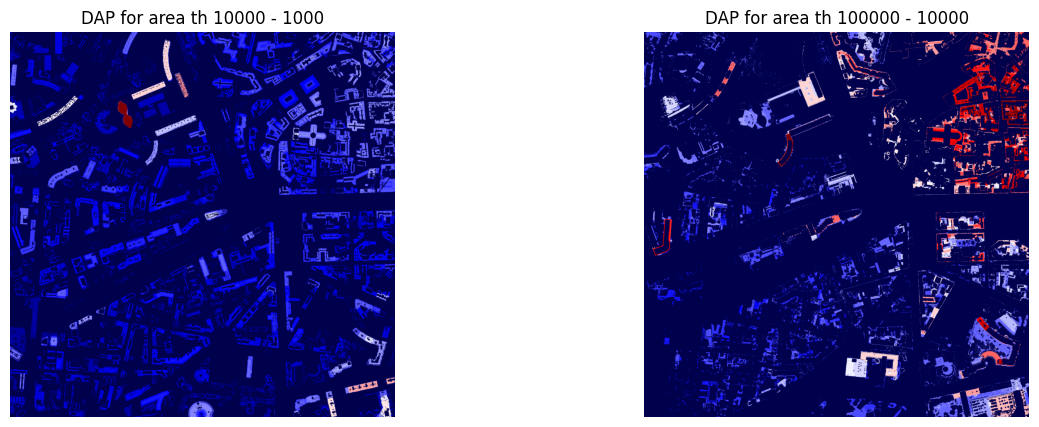

In [ ]:
# Your turn!

DAP = np.diff(profile_array, axis=-1)
print(DAP.shape)

## plotting
plt.figure(figsize=(15, 5))
for i in range(DAP.shape[-1]):
    plt.subplot(1, DAP.shape[-1], i+1)
    plt.imshow(DAP[:, :, i], cmap="seismic")
    plt.title(f"DAP for area th {thresholds[i+1]} - {thresholds[i]}")
    plt.axis("off")
plt.show()

## 3. Compute and display complete APs (min and max), Differential APs and Self-dual Attribute Profiles

In [24]:
# Don't panic, we'll use SAP!


#Compute and display complete APs (min and max), Differential APs and Self-dual Attribute Profiles

t_max = sap.MaxTree(dsm_no_nan)
t_min = sap.MinTree(dsm_no_nan)
thresholds = [1000, 10000, 100000]

#max tree AP
attr_max = t_max.get_attribute('area')
max_profile = []
for th in thresholds:
    filtered = t_max.reconstruct(attr_max >= th)
    max_profile.append(filtered)

#min tree AP
attr_min = t_min.get_attribute('area')
min_profile = []
for th in thresholds[::-1]:
    filtered = t_min.reconstruct(attr_min >= th) # or <= threshold 
    min_profile.append(filtered)

#stacking
max_profile_array = np.stack(max_profile, axis=-1)
min_profile_array = np.stack(min_profile, axis=-1)

##Full AP 
full_AP = np.concatenate((min_profile_array, dsm_no_nan [:, :, None],  max_profile_array), axis=-1)

print("Full AP complete shape :", full_AP.shape)  # (shape: height, width, n_thresholds*2 + 1)






Full AP complete shape : (2001, 2001, 7)


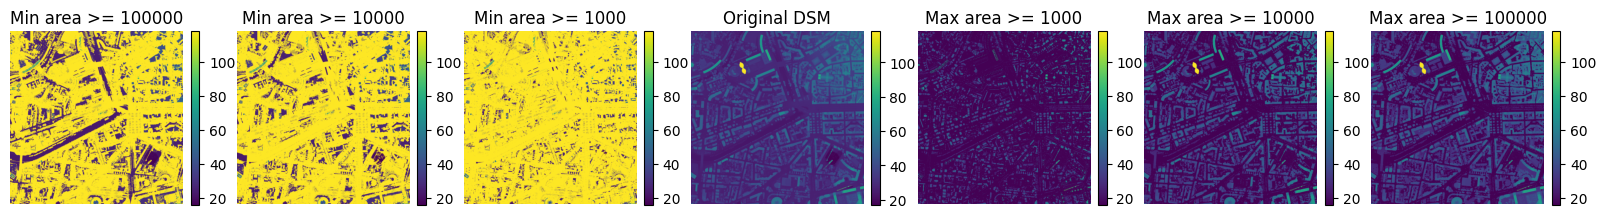

In [28]:
## plotting 
plt.figure(figsize=(20, 5))
for i in range(full_AP.shape[-1]):
    plt.subplot(1, full_AP.shape[-1], i+1)
    plt.imshow(full_AP[:, :, i], cmap="viridis")
    #add color bar
    plt.colorbar(fraction=0.046, pad=0.04)
    if i < len(thresholds):
        plt.title(f"Min area >= {thresholds[len(thresholds)-1 - i]}")
    elif i == len(thresholds):
        plt.title("Original DSM")
    else:
        plt.title(f"Max area >= {thresholds[i - len(thresholds) -1]}")
    plt.axis("off")
plt.show()

DAP shape : (2001, 2001, 4)


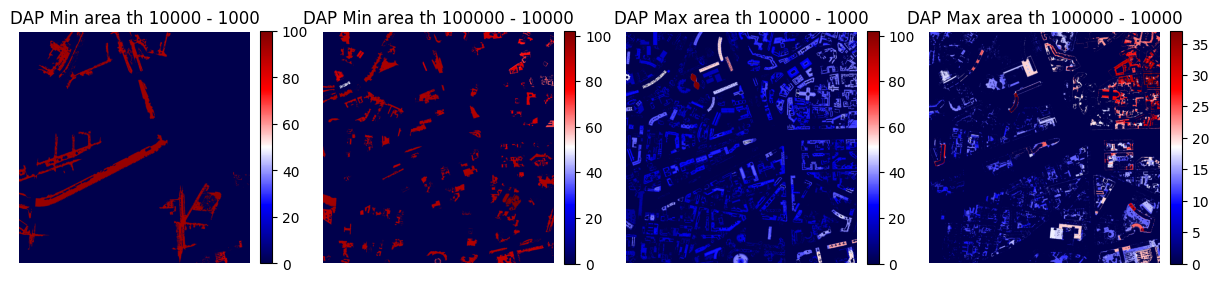

In [30]:
## Differential AP
DAP_max = np.diff(max_profile_array, axis=-1)
DAP_min = np.diff(min_profile_array, axis=-1)
DAP = np.concatenate((DAP_min, DAP_max), axis=-1)
print("DAP shape :", DAP.shape)  # (shape: height, width, (n_thresholds-1)*2)

# plotting
plt.figure(figsize=(15, 5))
for i in range(DAP.shape[-1]):
    plt.subplot(1, DAP.shape[-1], i+1)
    plt.imshow(DAP[:, :, i], cmap="seismic")
    plt.colorbar(fraction=0.046, pad=0.04)
    if i < DAP_min.shape[-1]:
        plt.title(f"DAP Min area th {thresholds[i+1]} - {thresholds[i]}")
    else:
        plt.title(f"DAP Max area th {thresholds[i - DAP_min.shape[-1] +1]} - {thresholds[i - DAP_min.shape[-1]]}")
    plt.axis("off")



In [35]:
## Self-dual AP
SDAP = sap.self_dual_attribute_profiles(dsm_no_nan, attribute= {'area': [1000, 10000, 100000]}, adjacency=4)


Total:   0%|          | 0/4 [00:00<?, ?it/s]

area:   0%|          | 0/4 [00:00<?, ?it/s]

In [36]:
print("SDAP", SDAP)

SDAP Profiles{'attribute': 'area',
 'filtering rule': 'direct',
 'name': 'self dual attribute profiles',
 'out feature': 'altitude',
 'profiles': [{'operation': 'copy feature altitude'},
              {'operation': 'sd filtering', 'threshold': 1000},
              {'operation': 'sd filtering', 'threshold': 10000},
              {'operation': 'sd filtering', 'threshold': 100000}],
 'tree': {'adjacency': 4, 'image_hash': '4d9ddb6b', 'image_name': None}}


In [41]:
SDAP.data

array([[[29, 29, 29, ..., 50, 53, 52],
        [29, 29, 29, ..., 48, 53, 53],
        [30, 29, 29, ..., 50, 54, 54],
        ...,
        [43, 43, 43, ..., 48, 48, 45],
        [43, 43, 43, ..., 46, 47, 45],
        [42, 42, 43, ..., 46, 47, 46]],

       [[29, 29, 29, ..., 48, 48, 48],
        [29, 29, 29, ..., 48, 48, 48],
        [29, 29, 29, ..., 48, 48, 48],
        ...,
        [32, 32, 32, ..., 39, 39, 39],
        [32, 32, 32, ..., 39, 39, 39],
        [32, 32, 32, ..., 39, 39, 39]],

       [[28, 28, 28, ..., 42, 42, 42],
        [28, 28, 28, ..., 42, 42, 42],
        [28, 28, 28, ..., 42, 42, 42],
        ...,
        [25, 25, 25, ..., 37, 37, 37],
        [25, 25, 25, ..., 37, 37, 37],
        [25, 25, 25, ..., 37, 37, 37]],

       [[27, 27, 27, ..., 38, 38, 38],
        [27, 27, 27, ..., 38, 38, 38],
        [27, 27, 27, ..., 38, 38, 38],
        ...,
        [25, 25, 25, ..., 26, 26, 26],
        [25, 25, 25, ..., 26, 26, 26],
        [25, 25, 25, ..., 26, 26, 26]]],
    

In [42]:
SDAP.__dict__

{'data': array([[[29, 29, 29, ..., 50, 53, 52],
         [29, 29, 29, ..., 48, 53, 53],
         [30, 29, 29, ..., 50, 54, 54],
         ...,
         [43, 43, 43, ..., 48, 48, 45],
         [43, 43, 43, ..., 46, 47, 45],
         [42, 42, 43, ..., 46, 47, 46]],
 
        [[29, 29, 29, ..., 48, 48, 48],
         [29, 29, 29, ..., 48, 48, 48],
         [29, 29, 29, ..., 48, 48, 48],
         ...,
         [32, 32, 32, ..., 39, 39, 39],
         [32, 32, 32, ..., 39, 39, 39],
         [32, 32, 32, ..., 39, 39, 39]],
 
        [[28, 28, 28, ..., 42, 42, 42],
         [28, 28, 28, ..., 42, 42, 42],
         [28, 28, 28, ..., 42, 42, 42],
         ...,
         [25, 25, 25, ..., 37, 37, 37],
         [25, 25, 25, ..., 37, 37, 37],
         [25, 25, 25, ..., 37, 37, 37]],
 
        [[27, 27, 27, ..., 38, 38, 38],
         [27, 27, 27, ..., 38, 38, 38],
         [27, 27, 27, ..., 38, 38, 38],
         ...,
         [25, 25, 25, ..., 26, 26, 26],
         [25, 25, 25, ..., 26, 26, 26],
       

In [52]:
SDAP_array = SDAP.data
print(SDAP_array.shape)


(4, 2001, 2001)


In [57]:
SDAP_array = SDAP.data.transpose(1, 2, 0)  # shape: (height, width, profiles)
print(SDAP_array.shape)

(2001, 2001, 4)


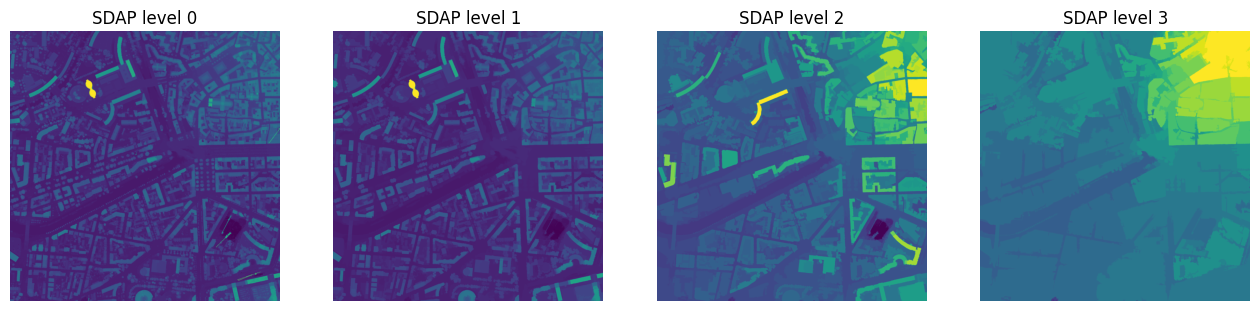

In [58]:
n = SDAP_array.shape[-1]

%matplotlib inline
plt.figure(figsize=(4*n, 4))
for i in range(n):
    plt.subplot(1, n, i+1)
    plt.imshow(SDAP_array[:, :, i], cmap="viridis")
    plt.title(f"SDAP level {i}")
    plt.axis("off")

plt.show()


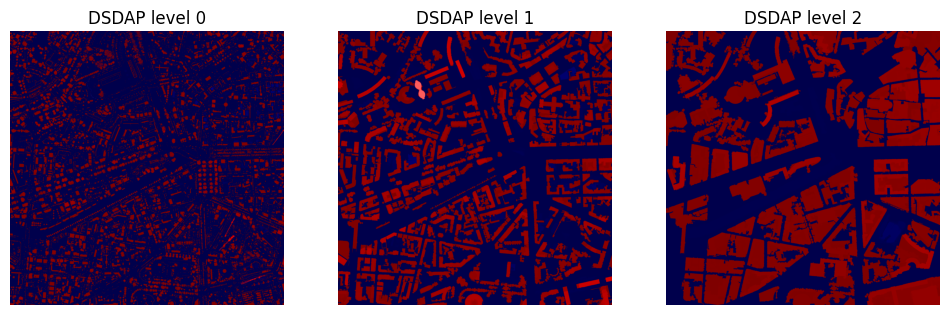

In [59]:
## Differential Self-dual AP
%matplotlib inline

DSDAP = np.diff(SDAP_array, axis=-1)

plt.figure(figsize=(4*DSDAP.shape[-1], 4))
for i in range(DSDAP.shape[-1]):
    plt.subplot(1, DSDAP.shape[-1], i+1)
    plt.imshow(DSDAP[:, :, i], cmap="seismic")
    plt.title(f"DSDAP level {i}")
    plt.axis("off")

plt.show()


In [55]:
print(type(SDAP))
print(type(SDAP.data))
print(SDAP.data.shape)
print(np.min(SDAP.data), np.max(SDAP.data))


<class 'sap.profiles.Profiles'>
<class 'numpy.ndarray'>
(4, 2001, 2001)
16 118


## DRAFT

In [60]:
# Your turn!
AP = sap.create_profiles(dsm_no_nan, {'area': [1000, 10000, 100000]},(sap.MinTree, sap.MaxTree))

## Filter the tree according to these thresholds, stack the filtered images!
#filtered_images, deleted_nodes = AP.filter_trees()


# Display the profiles (as in the intro image)
sap.plot_profiles(AP, dsm_no_nan)




Total:   0%|          | 0/14 [00:00<?, ?it/s]

area:   0%|          | 0/14 [00:00<?, ?it/s]

AttributeError: 'numpy.ndarray' object has no attribute 'operation_name'